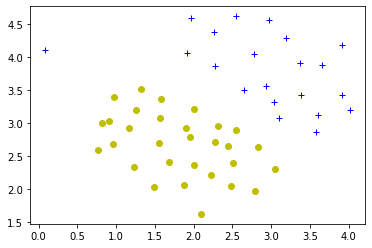

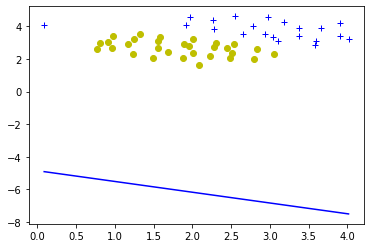

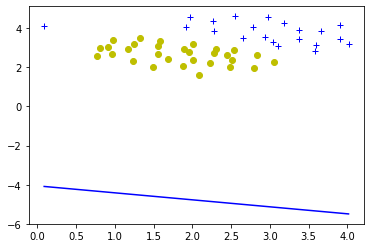

Gaussian kernel: 0.324652


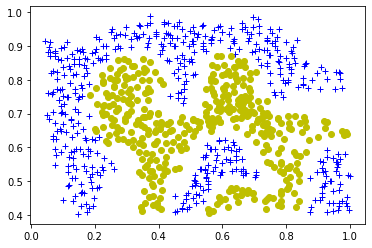

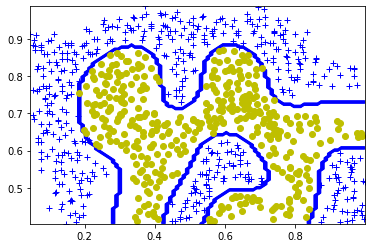

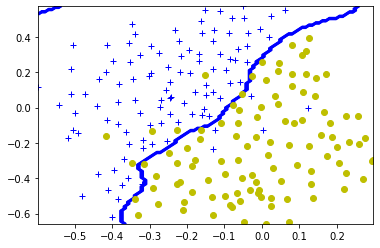

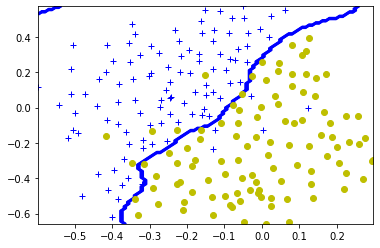

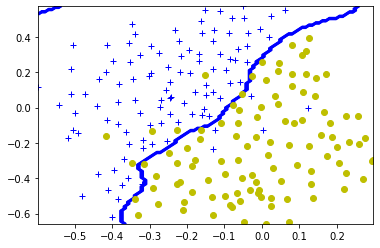

In [1]:
%matplotlib inline
import sys
import scipy.misc, scipy.io, scipy.optimize
from sklearn import svm, model_selection
from numpy import *

import pylab
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.mlab as mlaba

from util import Util

EX_DIRECTORY_PATH = './data/'

def plot(data):
    positives = data[data[:, 2] == 1]
    negatives = data[data[:, 2] == 0]

    pyplot.plot( positives[:, 0], positives[:, 1], 'b+' )
    pyplot.plot( negatives[:, 0], negatives[:, 1], 'yo' )

def gaussianKernel(x1, x2, sigma):
    return exp( -sum((x1 - x2) **2.0) / (2 * sigma**2.0) )

def visualizeBoundary( X, trained_svm ):
    kernel = trained_svm.get_params()['kernel']
    if kernel == 'linear':
        w     = trained_svm.dual_coef_.dot( trained_svm.support_vectors_ ).flatten()
        xp     = linspace( min(X[:, 0]), max(X[:, 0]), 100 )
        yp     = (-w[0] * xp + trained_svm.intercept_) / w[1]
        pyplot.plot( xp, yp, 'b-')
        

    elif kernel == 'rbf':
        x1plot = linspace( min(X[:, 0]), max(X[:, 0]), 100 )
        x2plot = linspace( min(X[:, 1]), max(X[:, 1]), 100 )
        
        X1, X2 = meshgrid( x1plot, x2plot )
        vals = zeros(shape(X1))
        
        for i in range(0, shape(X1)[1]):
            this_X = c_[ X1[:, i], X2[:, i] ]
            vals[:, i] = trained_svm.predict( this_X )
        
        pyplot.contour( X1, X2, vals, colors='blue' )

def dataset3ParamsVer3( X, y, X_val, y_val ):
    C_values      = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    sigma_values  = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    gammas        = list(map( lambda x: 1.0 / x, sigma_values ))
        
    raveled_y = y.ravel()

    rbf_svm     = svm.SVC()
    parameters    = {'kernel':('linear', 'rbf'), 'C':[0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30], 'gamma':gammas }
    grid         = model_selection.GridSearchCV( rbf_svm, parameters )
    best         = grid.fit( X, raveled_y ).best_params_

    return best
    
def dataset3ParamsVer2( X, y, X_val, y_val ):
    C_values      = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    sigma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

    raveled_y     = y.ravel()         # Else the SVM will give you annoying warning
    m_val         = shape( X_val )[0] # number of entries in validation data
    
    rbf_svm     = svm.SVC(kernel='rbf')

    best = {'score': -999, 'C': 0.0, 'sigma': 0.0 }

    for C in C_values:
        for sigma in sigma_values:
            # train the SVM first
            rbf_svm.set_params( C=C )
            rbf_svm.set_params( gamma = 1.0 / sigma )
            rbf_svm.fit( X, raveled_y )

            score = rbf_svm.score( X_val, y_val )
            
            # get the lowest error
            if score > best['score']:
                best['score']     = score
                best['C']         = C
                best['sigma']     = sigma

    best['gamma'] = 1.0 / best['sigma']
    return best


def dataset3ParamsVer1( X, y, X_val, y_val ):
    C_values      = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
    sigma_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

    raveled_y     = y.ravel() # Else the SVM will give you annoying warning
    m_val         = shape( X_val )[0] # number of entries in validation data
    
    rbf_svm     = svm.SVC(kernel='rbf')

    best = {'error': 999, 'C': 0.0, 'sigma': 0.0 }

    for C in C_values:
        for sigma in sigma_values:
            # train the SVM first
            rbf_svm.set_params( C=C )
            rbf_svm.set_params( gamma = 1.0 / sigma )
            rbf_svm.fit( X, raveled_y )

            # test it out on validation data
            predictions = []
            for i in range( 0, m_val ):
                prediction_result = rbf_svm.predict( array(X_val[i]).reshape(1,-1) )
                predictions.append( prediction_result[0] )

            # sadly if you don't reshape it, numpy doesn't know if it's row or column vector
            predictions = array(predictions).reshape( m_val, 1) 
            error = (predictions != y_val.reshape(m_val, 1)).mean()
            
            # get the lowest error
            if error < best['error']:
                best['error']     = error
                best['C']         = C
                best['sigma']     = sigma

    best['gamma'] = 1.0 / best['sigma']
    return best


def part1_1():
    mat = scipy.io.loadmat( EX_DIRECTORY_PATH + "ex6data1.mat" )
    X, y = mat['X'], mat['y']

    plot( c_[X, y] )
    pyplot.show( block=True )

    # linear SVM with C = 1
    linear_svm = svm.SVC(C=1, kernel='linear')
    linear_svm.fit( X, y.ravel() )

    plot( c_[X, y] )
    visualizeBoundary( X, linear_svm )
    pyplot.show( block=True )    

    # try with C = 100
    linear_svm.set_params( C=100 )    
    linear_svm.fit( X, y.ravel() )

    plot( c_[X, y] )
    visualizeBoundary( X, linear_svm )
    pyplot.show( block=True )    

def part1_2():
    x1 = array([1, 2, 1])
    x2 = array([0, 4, -1])
    sigma = 2

    print ("Gaussian kernel: %f" % gaussianKernel( x1, x2, sigma ))

    mat = scipy.io.loadmat( EX_DIRECTORY_PATH + "ex6data2.mat" )
    X, y = mat['X'], mat['y']

    plot( c_[X, y] )
    pyplot.show( block=True )

    sigma = 0.01
    rbf_svm = svm.SVC(C=1, kernel='rbf', gamma = 1.0 / sigma ) # gamma is actually inverse of sigma
    rbf_svm.fit( X, y.ravel() )

    plot( c_[X, y] )
    visualizeBoundary( X, rbf_svm )
    
    pyplot.show( block=True ) 
    
def part1_3():
    mat            = scipy.io.loadmat( EX_DIRECTORY_PATH + "ex6data3.mat" )
    X, y           = mat['X'], mat['y']
    X_val, y_val = mat['Xval'], mat['yval']

    rbf_svm = svm.SVC(kernel='rbf')

    best = dataset3ParamsVer1( X, y, X_val, y_val )
    rbf_svm.set_params( C=best['C'] )
    rbf_svm.set_params( gamma=best['gamma'] )
    rbf_svm.fit( X, y )

    plot( c_[X, y] )
    visualizeBoundary( X, rbf_svm )
    pyplot.show( block=True)
    
    best = dataset3ParamsVer2( X, y, X_val, y_val )
    rbf_svm.set_params( C=best['C'] )
    rbf_svm.set_params( gamma=best['gamma'] )

    plot( c_[X, y] )
    visualizeBoundary( X, rbf_svm )
    pyplot.show( block=True)

    best = dataset3ParamsVer3( X, y, X_val, y_val )
    rbf_svm.set_params( C=best['C'] )
    rbf_svm.set_params( gamma=best['gamma'] )

    plot( c_[X, y] )
    visualizeBoundary( X, rbf_svm )
    pyplot.show( block=True)


def main():
    set_printoptions(precision=6, linewidth=200)
    part1_1()
    part1_2()
    part1_3()
    

if __name__ == '__main__':
    main()